## Imports

In [1]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3095459 sha256=4fb2c98fe3a80850940318ecdedaf0fcac13ceb2dd5e3106cfabfda68aabf9fe
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline
from sklearn.metrics import mean_squared_error
from numpy.linalg import norm
from random import normalvariate
from scipy.sparse.linalg import svds
from surprise import Dataset
from surprise import SVD, SVDpp
from surprise import accuracy
from surprise.model_selection import train_test_split, KFold
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Data

Read files from Google drive and let's load 2 data files needed for this project.

In [3]:
ratings = pd.read_csv('/content/drive/MyDrive/mmml-data/ratings.csv')
movies = pd.read_csv('/content/drive/MyDrive/mmml-data/movies.csv')

Let's take a look at the movies and ratings dataframes.

In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


## EDA

Let's explore the data a bit and get a look at some of the best rated movies.

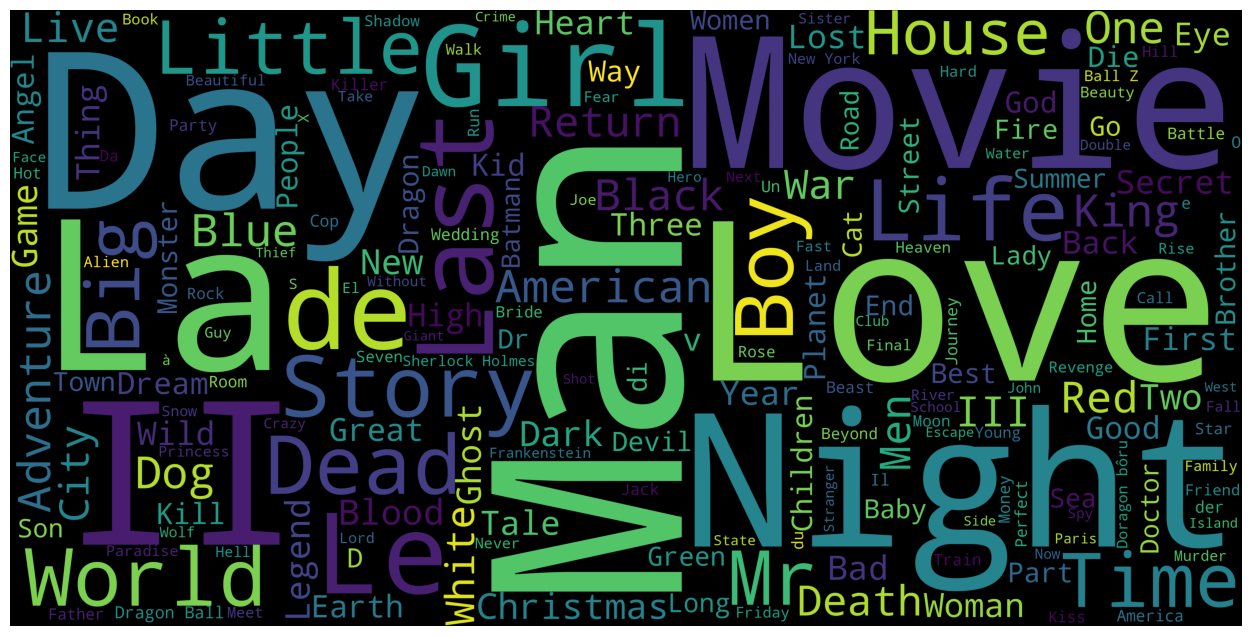

In [6]:
# Create a wordcloud of the movie titles
df_movies = movies.copy()
df_movies['title'] = df_movies['title'].fillna("").astype('str')
title_corpus = ' '.join(df_movies['title'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

As we can see, words like Day, Love, Movie, World, Night, Story, Last are among the most commonly occuring words. In additionm we can see latin symbol of 2 in the right lower corner, which specifies that there are some franchise movies.

In [7]:
df_merged = pd.merge(ratings,movies,on='movieId')
df_merged = df_merged.drop(["genres"], axis=1)
df_merged.head()

,userId,movieId,rating,timestamp,title
0,1,1,4.0,964982703,Toy Story (1995)
1,5,1,4.0,847434962,Toy Story (1995)
2,7,1,4.5,1106635946,Toy Story (1995)
3,15,1,2.5,1510577970,Toy Story (1995)
4,17,1,4.5,1305696483,Toy Story (1995)


In [8]:
df_merged.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
Name: rating, dtype: int64

As we can see, the most ratedmovie is Forrest Gump (1994), having more than 300 reviews in our database!

In [9]:
ratings_separate = pd.DataFrame(df_merged.groupby('title')['rating'].mean())
ratings_separate.head()

,rating
title,
'71 (2014),4.0
'Hellboy': The Seeds of Creation (2004),4.0
'Round Midnight (1986),3.5
'Salem's Lot (2004),5.0
'Til There Was You (1997),4.0


In [10]:
ratings_separate['num_ratings'] = pd.DataFrame(df_merged.groupby('title')['rating'].count())
ratings_separate.head()

,rating,num_ratings
title,,
'71 (2014),4.0,1
'Hellboy': The Seeds of Creation (2004),4.0,1
'Round Midnight (1986),3.5,2
'Salem's Lot (2004),5.0,1
'Til There Was You (1997),4.0,2


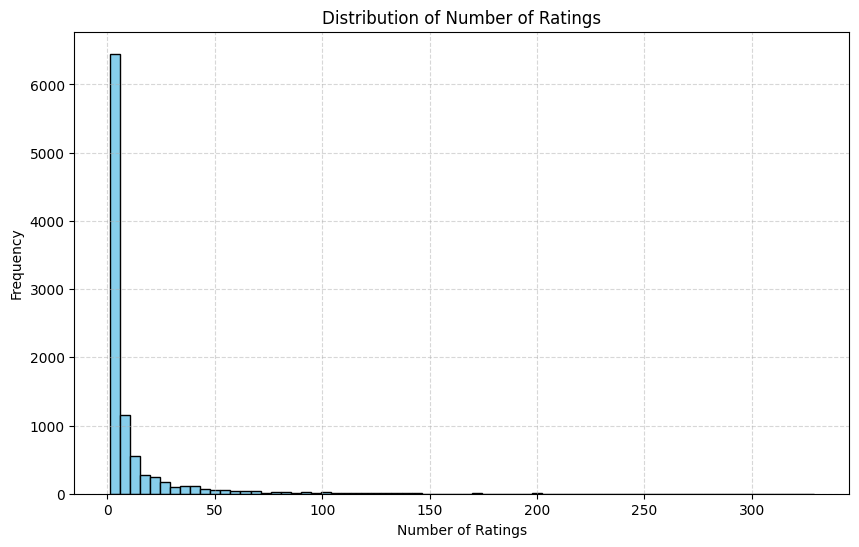

In [11]:
plt.figure(figsize=(10, 6))
plt.hist(ratings_separate['num_ratings'], bins=70, edgecolor='black', color='skyblue')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Ratings')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

As we can spectate, usually users are rating not so many movies, usually around 5-20.

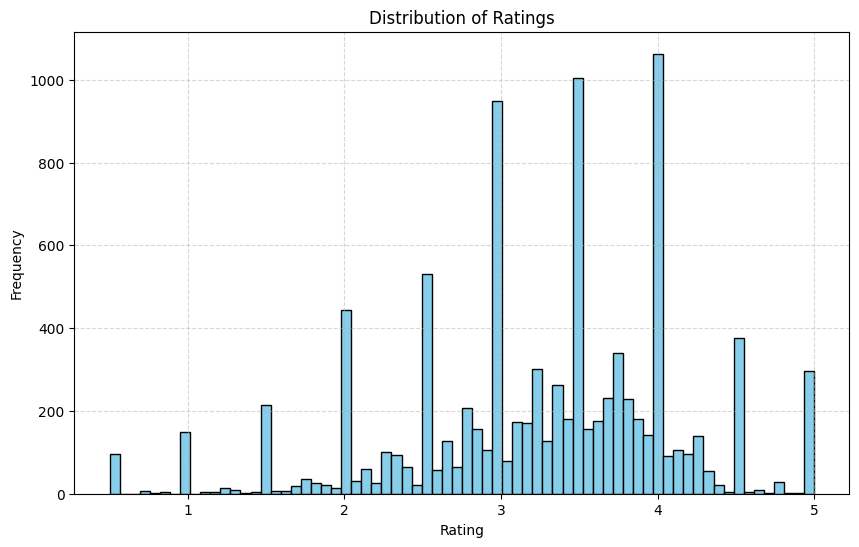

In [12]:
plt.figure(figsize=(10, 6))
plt.hist(ratings_separate['rating'], bins=70, edgecolor='black', color='skyblue')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.xticks(range(1, 6))
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

From the plot above we observe that usually movies are having rating around 3-4 points our of 5. 

## SVD

Let's prepare a dataset for this. We need a matrxi of user-movie relationship, where we will have rows represent users, and columns as each movie in our dataset

In [13]:
ratings_svd = ratings.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
ratings_svd.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In addition, it is important as for other models to denormalize data. For this we will substract the mean of user rating from the whole dataset.

In [14]:
ratings_svd_matrix = ratings_svd.values
user_ratings_mean_value = np.mean(ratings_svd_matrix, axis = 1)
ratings_svd_denormalized = ratings_svd_matrix - user_ratings_mean_value.reshape(-1, 1)

Scipy and Numpy both have functions to perform SVD. However, we decided to use the scipy function since it allows to set the number of latent factors we want to use to approximate the original ratings matrix (instead of having to truncate it after after getting from Numpy function).

In [15]:
U, sigma, Vt = svds(ratings_svd_denormalized, k = 20)

In [16]:
sigma = np.diag(sigma)

In [17]:
predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean_value.reshape(-1, 1)
predictions_scipy_csv = pd.DataFrame(predicted_ratings, columns = ratings_svd.columns)
predictions_scipy_csv.head(10)

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
0,2.390233,1.445417,1.044432,-0.058724,0.009513,1.254817,0.050700,0.068028,0.064673,1.420825,...,-0.008270,-0.007096,-0.009444,-0.009444,-0.008270,-0.009444,-0.008270,-0.008270,-0.008270,-0.041128
1,0.026769,0.015107,0.013651,0.003646,0.016343,-0.010475,-0.028568,-0.000338,0.007754,-0.111777,...,0.011806,0.010278,0.013334,0.013334,0.011806,0.013334,0.011806,0.011806,0.011806,0.016815
2,-0.019490,0.041808,0.046567,0.003080,-0.036515,0.046026,-0.019498,0.014127,0.002277,-0.009803,...,0.008835,0.008859,0.008812,0.008812,0.008835,0.008812,0.008835,0.008835,0.008835,0.006786
3,2.274201,0.062059,0.029332,0.057391,0.221459,0.487771,0.332382,-0.057574,0.019314,0.227430,...,-0.006950,-0.007243,-0.006657,-0.006657,-0.006950,-0.006657,-0.006950,-0.006950,-0.006950,-0.017749
4,1.359442,0.971920,0.340771,0.119166,0.480792,0.630626,0.507704,0.135391,0.039980,1.121030,...,-0.001817,-0.001875,-0.001759,-0.001759,-0.001817,-0.001759,-0.001817,-0.001817,-0.001817,-0.000694
5,3.164536,3.297748,2.062653,0.479390,2.070666,2.487073,2.490815,0.623888,0.644313,4.186118,...,0.047434,0.046762,0.048107,0.048107,0.047434,0.048107,0.047434,0.047434,0.047434,0.042145
6,2.142028,0.739659,-0.057247,-0.023406,0.159626,1.015579,0.119230,-0.089697,0.062841,1.287514,...,-0.011659,-0.010214,-0.013103,-0.013103,-0.011659,-0.013103,-0.011659,-0.011659,-0.011659,0.002679
7,1.579164,1.265337,0.516404,0.150376,0.626113,0.879905,0.649555,0.167259,0.063061,1.530889,...,-0.003910,-0.003862,-0.003959,-0.003959,-0.003910,-0.003959,-0.003910,-0.003910,-0.003910,0.000525
8,0.433147,0.009618,-0.001021,-0.000144,0.040402,0.062081,0.005671,-0.017717,0.027148,0.146803,...,0.004938,0.004898,0.004978,0.004978,0.004938,0.004978,0.004938,0.004938,0.004938,0.007938
9,1.215688,0.360788,-0.043043,0.034653,0.252847,-0.397116,0.179493,-0.013756,-0.011716,-0.156744,...,0.032594,0.030899,0.034288,0.034288,0.032594,0.034288,0.032594,0.032594,0.032594,0.042994


In [18]:
actual = []
pred = []
for _, row in ratings.iterrows():
    actual.append(row['rating'])
    pred.append(predictions_scipy_csv.at[int(row['userId']) - 1, int(row['movieId'])])

In [19]:
print(f"RMSE is: ", mean_squared_error(actual, pred, squared=False))

RMSE is:  2.362034411789046


In [20]:
data = Dataset.load_builtin('ml-100k')
train_set = data.build_full_trainset()

Dataset ml-100k could not be found. Do you want to download it? [Y/n] y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


In [21]:
algo_funk = SVD(biased=False)
algo_bias = SVD()
algo_pp = SVDpp()

kf = KFold(n_splits=3)
for trainset, testset in kf.split(data):
    #SVD without bias
    algo_funk.fit(trainset)
    predictions_funk = algo_funk.test(testset)
    #SVD with bias
    algo_bias.fit(trainset)
    predictions_bias = algo_bias.test(testset)
    # SVD++
    algo_pp.fit(trainset)
    predictions_pp = algo_pp.test(testset)
    
    print('funkSVD')
    accuracy.rmse(predictions_funk, verbose=True)
    print('biasSVD')
    accuracy.rmse(predictions_bias, verbose=True)
    print('SVD++')
    accuracy.rmse(predictions_pp, verbose=True)

funkSVD
RMSE: 0.9641
biasSVD
RMSE: 0.9454
SVD++
RMSE: 0.9244
funkSVD
RMSE: 0.9701
biasSVD
RMSE: 0.9412
SVD++
RMSE: 0.9266
funkSVD
RMSE: 0.9655
biasSVD
RMSE: 0.9434
SVD++
RMSE: 0.9289


In [22]:
def randomUnitVector(n):
    unnormalized = [normalvariate(0, 1) for _ in range(n)]
    theNorm = np.sqrt(sum(x * x for x in unnormalized))
    return [x / theNorm for x in unnormalized]


def svd_1d(matrix, epsilon=1e-10):
    """
    The one-dimensional SVD
    """

    n, m = matrix.shape
    x = randomUnitVector(min(n,m))
    last_vector = None
    current_vector = x

    if n > m:
        B = np.dot(matrix.T, matrix)
    else:
        B = np.dot(matrix, matrix.T)

    iterations = 0
    while True:
        iterations += 1
        last_vector = current_vector
        current_vector = np.dot(B, last_vector)
        current_vector = current_vector / norm(current_vector)

        if abs(np.dot(current_vector, last_vector)) > 1 - epsilon:
            print("converged in {} iterations!".format(iterations))
            return current_vector


def svd(A, k=None, epsilon=1e-10):
    """
    Compute the singular value decomposition of a matrix A
    using the power method.
    """
    A = np.array(A, dtype=float)
    n, m = A.shape
    svd = []
    if k > min(m, n):
      raise ValueError("k must not be greater than both m and n")
    if k is None:
        k = min(n, m)

    for i in range(k):
        matrix_1D = A.copy()

        for singular_value, u, v in svd[:i]:
            matrix_1D -= singular_value * np.outer(u, v)

        if n > m:
            v = svd_1d(matrix_1D, epsilon=epsilon)  # next singular vector
            u_unnormalized = np.dot(A, v)
            sigma = norm(u_unnormalized)  # next singular value
            u = u_unnormalized / sigma
        else:
            u = svd_1d(matrix_1D, epsilon=epsilon)  # next singular vector
            v_unnormalized = np.dot(A.T, u)
            sigma = norm(v_unnormalized)  # next singular value
            v = v_unnormalized / sigma

        svd.append((sigma, u, v))

    singular_values, us, vs = [np.array(x) for x in zip(*svd)]
    return singular_values, us.T, vs

In [23]:
sigma_our_svd, U_our_svd, Vt_our_svd = svd(ratings_svd_denormalized, k=20)

converged in 12 iterations!
converged in 21 iterations!
converged in 41 iterations!
converged in 78 iterations!
converged in 54 iterations!
converged in 98 iterations!
converged in 57 iterations!
converged in 231 iterations!
converged in 61 iterations!
converged in 96 iterations!
converged in 206 iterations!
converged in 360 iterations!
converged in 114 iterations!
converged in 192 iterations!
converged in 746 iterations!
converged in 214 iterations!
converged in 105 iterations!
converged in 285 iterations!
converged in 252 iterations!
converged in 354 iterations!


In [24]:
sigma_our_svd = np.diag(sigma_our_svd)

In [25]:
predicted_ratings_our_csv = np.dot(np.dot(U_our_svd, sigma_our_svd), Vt_our_svd) + user_ratings_mean_value.reshape(-1, 1)
predictions_our_svd = pd.DataFrame(predicted_ratings_our_csv, columns = ratings_svd.columns)
predictions_our_svd.head(10)

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
0,2.390702,1.445403,1.044540,-0.058704,0.009654,1.255087,0.050912,0.068061,0.064827,1.420543,...,-0.008272,-0.007097,-0.009447,-0.009447,-0.008272,-0.009447,-0.008272,-0.008272,-0.008272,-0.041132
1,0.026733,0.015108,0.013639,0.003644,0.016329,-0.010498,-0.028585,-0.000341,0.007742,-0.111756,...,0.011806,0.010278,0.013334,0.013334,0.011806,0.013334,0.011806,0.011806,0.011806,0.016815
2,-0.019528,0.041809,0.046559,0.003079,-0.036526,0.046005,-0.019515,0.014125,0.002265,-0.009780,...,0.008835,0.008859,0.008812,0.008812,0.008835,0.008812,0.008835,0.008835,0.008835,0.006786
3,2.274315,0.062046,0.029198,0.057375,0.221385,0.487689,0.332379,-0.057579,0.019317,0.227365,...,-0.006949,-0.007242,-0.006656,-0.006656,-0.006949,-0.006656,-0.006949,-0.006949,-0.006949,-0.017756
4,1.359501,0.971919,0.340794,0.119170,0.480815,0.630668,0.507734,0.135396,0.040002,1.120995,...,-0.001818,-0.001875,-0.001760,-0.001760,-0.001818,-0.001760,-0.001818,-0.001818,-0.001818,-0.000695
5,3.164161,3.297735,2.062177,0.479324,2.070292,2.486499,2.490512,0.623829,0.644106,4.186352,...,0.047439,0.046767,0.048112,0.048112,0.047439,0.048112,0.047439,0.047439,0.047439,0.042134
6,2.142085,0.739661,-0.057172,-0.023396,0.159685,1.015669,0.119277,-0.089688,0.062873,1.287478,...,-0.011659,-0.010215,-0.013104,-0.013104,-0.011659,-0.013104,-0.011659,-0.011659,-0.011659,0.002680
7,1.579113,1.265344,0.516473,0.150384,0.626151,0.879950,0.649559,0.167262,0.063062,1.530917,...,-0.003911,-0.003863,-0.003959,-0.003959,-0.003911,-0.003959,-0.003911,-0.003911,-0.003911,0.000528
8,0.433103,0.009619,-0.001040,-0.000147,0.040383,0.062048,0.005648,-0.017721,0.027132,0.146830,...,0.004938,0.004898,0.004978,0.004978,0.004938,0.004978,0.004938,0.004938,0.004938,0.007938
9,1.215465,0.360801,-0.042977,0.034659,0.252859,-0.397136,0.179432,-0.013762,-0.011764,-0.156612,...,0.032593,0.030899,0.034288,0.034288,0.032593,0.034288,0.032593,0.032593,0.032593,0.043000


In [26]:
actual_our_svd = []
pred_our_csv = []
for _, row in ratings.iterrows():
    actual_our_svd.append(row['rating'])
    pred_our_csv.append(predictions_our_svd.at[int(row['userId']) - 1, int(row['movieId'])])

In [27]:
print(f"RMSE is: ", mean_squared_error(actual_our_svd, pred_our_csv, squared=False))

RMSE is:  2.3620351891338873


As we can see, we got the same result as the imported SVD!